In [1]:
import sys, os
sys.path.append("../..")
sys.path.append("..")
sys.path.append(os.getcwd())

from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import copy
import pickle

from mrsc.src.model.SVDmodel import SVDmodel
from mrsc.src.model.Target import Target
from mrsc.src.model.Donor import Donor
from mrsc.src.synthcontrol.mRSC import mRSC
from mrsc.src.importData import *
import mrsc.src.utils as utils

from itertools import combinations, product

In [2]:
def getActivePlayers(stats, year, buffer):
    # list of name of the players who were active in this and last year
    thisYear = stats[stats.Year == year].copy()
    players = list(thisYear.Player.unique())
    for i in range(1, buffer+1):
        previousYear = stats[stats.Year == (year-i)].copy()
        players = list(set(players) & set(previousYear.Player.unique()))
    return players

def topPlayers(stats, year, metric, n):
    stats = stats[stats.Year == year]
    stats = stats.groupby('Player').mean().reset_index()
    stats_sorted = stats[stats.Year == year].sort_values(metric, ascending = False).reset_index(drop=True)
    return stats_sorted[["Player","player_id"]][:n]

def removeDuplicated(players, stats):
    """
    players: "../data/nba-players-stats/player_data.csv"
    stats: "../data/nba-players-stats/Seasons_Stats.csv"
    """
    # players with the same name
    names = players.name.unique()
    duplicated = np.array([])

    for name in names:
        numrows = len(players[players.name == name])
        if numrows != 1:
            duplicated = np.append(duplicated, name)

    duplicated = np.sort(duplicated)

    start_year = players.copy()
    start_year = start_year.rename(columns={"name":"Player"})

    # for non-duplicated players
    stats_not_duplicated = stats[~stats.Player.isin(duplicated)]
    stats_not_duplicated = pd.merge(stats_not_duplicated, start_year, on="Player", how="left")

    # only take the values that make sense
    stats_not_duplicated = stats_not_duplicated[(stats_not_duplicated.Year >= stats_not_duplicated.year_start) & (stats_not_duplicated.Year <= stats_not_duplicated.year_end )]
    stats_not_duplicated["year_count"] = stats_not_duplicated.Year - stats_not_duplicated.year_start

    return stats_not_duplicated

def getMetrics(target, donor, pred_year, allMetrics, threshold, expSetup):
    target_data = target.concat(allMetrics, pred_year, pred_length=1)

    num_k = len(allMetrics)
    total_index = int(target_data.shape[1] / num_k)
    mat_form_method = expSetup[0]

    metrics_list = []
    for metric_of_interest in allMetrics:
        df = donor.concat([metric_of_interest], 2016, total_index, method = mat_form_method)
        apprx_rank = utils.approximate_rank(df, t = threshold)
        energy_captured = utils.svdAanlysis(df, title=metric_of_interest, verbose = False)[apprx_rank-1]

        metrics = [metric_of_interest]
        candidates = copy.deepcopy(allMetrics)
        candidates.remove(metric_of_interest)

        while True:
            energy_diff_df = pd.DataFrame()
            for metric in candidates:
                comb = metrics+[metric]
                df = donor.concat(comb, 2016, total_index, method = mat_form_method)
                energy_at_apprx_rank = utils.svdAanlysis(df, k=apprx_rank, verbose=False)[-1]
                
                if(energy_at_apprx_rank > threshold):
                    energy_diff = np.abs(energy_at_apprx_rank - energy_captured)
                    energy_diff_df = pd.concat([energy_diff_df, pd.DataFrame([[energy_diff]], index=[metric])], axis=0)
        #             print(energy_diff)
            if (energy_diff_df.shape[0] == 0):
                break
            new_metric = energy_diff_df.sort_values(0).index[0]
            metrics = metrics + [new_metric]
            candidates.remove(new_metric)
        metrics_list.append(metrics)
        print(metrics)

    return metrics_list

def getWeitghts(target, donor, metrics_list, expSetup, method = "mean"):   
    # get mat_form_method
    mat_form_method = expSetup[0] # "fixed"

    # get weights for metrics
    weights_list = []
    for metrics in metrics_list:
        target_data = target.concat(metrics, 2016, pred_length=1)
        num_k = len(metrics)
        total_index = int(target_data.shape[1] / num_k)
        donor_data = donor.concat(metrics, 2016, total_index, method = mat_form_method)

        if (method == "mean"):
            weights = []
            for i in range(num_k):
                weights.append(1/(donor_data.iloc[:,i*total_index:(i+1)*total_index].mean().mean()))
            weights_list.append(weights)
        elif (method == "var"):
            weights = []
            for i in range(num_k):
                weights.append(1/(1+np.var(donor_data.iloc[:,i*total_index:(i+1)*total_index].to_numpy().flatten())))
            weights_list.append(weights)
        else:
            raise ValueError("invalid method")
    return weights_list

# Clean Data

In [3]:
"""
import data
"""
players = pd.read_csv("../data/nba-players-stats/player_data.csv")
players = players[players.year_start >= 1980] # only choose players who started after 1980
players["player_id"] = range(0,len(players.name)) # assign id

stats = pd.read_csv("../data/nba-players-stats/Seasons_Stats.csv")
stats = stats[stats.Player.isin(players.name)]

# only after 1980
stats = stats[stats.Year >= 1980]

# without duplicated names --> to do: how to distinguish multiple player with the same name
stats = removeDuplicated(players, stats)
stats.Year = stats.Year.astype(int)
stats.year_count = stats.year_count.astype(int)

# transform stats to a dictionary composed of df's for each stat
# the stats are re-calculated to get one stat for each year

metricsPerGameColNames = ["PTS","AST","TOV","TRB","STL","BLK","3P"]
metricsPerGameDict = getMetricsPerGameDict(stats, metricsPerGameColNames)

metricsPerCentColNames = ["FG","FT"]
metricsPerCentDict = getMetricsPerCentDict(stats, metricsPerCentColNames)

metricsWeightedColNames = ["PER"]
metricsWeightedDict = getMetricsWeightedDict(stats, metricsWeightedColNames)

allMetricsDict = {**metricsPerGameDict, **metricsPerCentDict, **metricsWeightedDict}
allPivotedTableDict = getPivotedTableDict(allMetricsDict)
allMetrics = list(allMetricsDict.keys())

# this matrix will be used to mask the table
df_year = pd.pivot_table(stats, values="Year", index="Player", columns = "year_count")

In [4]:
allMetrics

['PTS_G',
 'AST_G',
 'TOV_G',
 'TRB_G',
 'STL_G',
 'BLK_G',
 '3P_G',
 'FG%',
 'FT%',
 'PER_w']

In [5]:
pred_year = 2016
# targets to test
activePlayers = getActivePlayers(stats, pred_year, 4)
activePlayers.sort()
# to few donors
activePlayers.remove("Kevin Garnett")
activePlayers.remove("Kobe Bryant")

# overall setup
expSetup = ["sliding", "SVD", "all", "pinv", False]
threshold = 0.97

# Baseline

In [56]:
metrics_to_use= ["PTS_G","AST_G","TOV_G","PER_w", "FG%","FT%","3P%","TRB_G","STL_G","BLK_G"]

print("Algo: outputs the mean of the player's history")
print("-----")
pred_all = pd.DataFrame()
true_all = pd.DataFrame()
for playerName in activePlayers:
    target = Target(playerName, allPivotedTableDict, df_year)
    target_data = target.concat(metrics_to_use, 2016, pred_length=1)
    num_k = len(metrics_to_use)
    interv_index = int(target_data.shape[1]/num_k -1)
    total_index = int(interv_index + 1)

    # true
    true = utils.get_postint_data(target_data, interv_index, total_index, num_k).T
    true.index = metrics_to_use

    # predictions
    history = utils.get_preint_data(target_data, interv_index, total_index, num_k)
    pred = []
    for i in range(num_k):
        pred.append(history.iloc[:,i*interv_index:(i+1)*interv_index].mean(axis=1).to_list())

    pred = pd.DataFrame(pred, index=metrics_to_use, columns = [playerName])

    pred_all = pd.concat([pred_all, pred], axis=1)
    true_all = pd.concat([true_all, true], axis=1)

###################
mask = (true_all !=0 )
mape = np.abs(pred_all - true_all) / true_all[mask]
print("*** MAPE ***")
print(mape.mean(axis=1))
print("MAPE for all: ", mape.mean().mean())
rmse = utils.rmse_2d(true_all, pred_all)
print()
print("*** RMSE ***")
print(rmse)
print("RMSE for all: ", rmse.mean())    

Algo: outputs the mean of the player's history
-----
*** MAPE ***
PTS_G    0.549117
AST_G    0.499593
TOV_G    0.586009
PER_w    0.285259
FG%      0.076325
FT%      0.081761
3P%      0.221556
TRB_G    0.411837
STL_G    0.443918
BLK_G    0.682211
dtype: float64
MAPE for all:  0.39739103180264496

*** RMSE ***
PTS_G    4.669743
AST_G    1.132015
TOV_G    0.614409
PER_w    3.775067
FG%      0.052802
FT%      0.099701
3P%      0.126288
TRB_G    1.703413
STL_G    0.299635
BLK_G    0.283370
dtype: float64
RMSE for all:  1.2756443185018567


### Off vs. Def

In [5]:
def getWeitghts(target, donor, metrics_list, expSetup, method = "mean"):   
    # get mat_form_method
    mat_form_method = expSetup[0] # "fixed"
    
    # get weights for metrics
    weights_list = []
    for metrics in metrics_list:
        target_data = target.concat(metrics, 2016, pred_length=1)
        num_k = len(metrics)
        total_index = int(target_data.shape[1] / num_k)
        donor_data = donor.concat(metrics, 2016, total_index, method = mat_form_method)
    
        if (method == "mean"):
            weights = []
            for i in range(num_k):
                weights.append(1/(donor_data.iloc[:,i*total_index:(i+1)*total_index].mean().mean()))
            weights_list.append(weights)
        elif (method == "var"):
            weights = []
            for i in range(num_k):
                weights.append(1/(1+np.var(donor_data.iloc[:,i*total_index:(i+1)*total_index].to_numpy().flatten())))
            weights_list.append(weights)
        else:
            raise ValueError("invalid method")
    return weights_list

In [6]:
offMetrics = ["PTS_G","AST_G","TOV_G","PER_w", "FG%","FT%","3P%"]
defMetrics = ["TRB_G","STL_G","BLK_G"]
metrics_list = [offMetrics, defMetrics]

print("start experiment - off/def with mean-standardized weights")
pred_all = pd.DataFrame()
true_all = pd.DataFrame()
for playerName in activePlayers:
    target = Target(playerName, allPivotedTableDict, df_year)
    donor = Donor(allPivotedTableDict, df_year)
    
    weights_list = getWeitghts(target, donor, metrics_list, expSetup, method="mean")

    mrsc = mRSC(donor, target, probObservation=1)
    mrsc.fit_threshold(offMetrics, weights_list[0], 2016, pred_length = 1, threshold = threshold, setup = expSetup)

    predOff = mrsc.predict()
    trueOff = mrsc.getTrue()
    predOff.columns = [playerName]
    trueOff.columns = [playerName]

    mrsc.fit_threshold(defMetrics, weights_list[1], 2016, pred_length = 1, threshold = threshold, setup = expSetup)
    predDef = mrsc.predict()
    trueDef = mrsc.getTrue()
    predDef.columns = [playerName]
    trueDef.columns = [playerName]

    pred = pd.concat([predOff, predDef], axis=0)
    true = pd.concat([trueOff, trueDef], axis=0)

    pred_all = pd.concat([pred_all, pred], axis=1)
    true_all = pd.concat([true_all, true], axis=1)

###################
mask = (true_all !=0 )
mape = np.abs(pred_all - true_all) / true_all[mask]
print("*** MAPE ***")
print(mape.mean(axis=1))
print("MAPE for all: ", mape.mean().mean())
rmse = utils.rmse_2d(true_all, pred_all)
print()
print("*** RMSE ***")
print(rmse)
print("RMSE for all: ", rmse.mean())    

start experiment - off/def with mean-standardized weights
*** MAPE ***
PTS_G    0.397267
AST_G    0.595518
TOV_G    0.408489
PER_w    0.258121
FG%      0.132499
FT%      0.129018
3P%      0.229390
TRB_G    0.302026
STL_G    0.370390
BLK_G    0.551463
dtype: float64
MAPE for all:  0.34719459241255957

*** RMSE ***
PTS_G    4.121269
AST_G    1.182825
TOV_G    0.562889
PER_w    4.312484
FG%      0.084788
FT%      0.134650
3P%      0.127436
TRB_G    1.461399
STL_G    0.286534
BLK_G    0.221178
dtype: float64
RMSE for all:  1.2495450976486413


# grouping

In [7]:
metrics1 = ["PTS_G","PER_w"]
metrics2 = ["TOV_G","FG%","FT%","3P%"]
metrics3 = ["TRB_G","STL_G",]
metrics4 = ["AST_G","BLK_G"]

metrics_list = [metrics1, metrics2, metrics3, metrics4]
    
print("start experiment - off/def with mean-standardized weights")
pred_all = pd.DataFrame()
true_all = pd.DataFrame()
for playerName in activePlayers:
    target = Target(playerName, allPivotedTableDict, df_year)
    donor = Donor(allPivotedTableDict, df_year)
    
    weights_list = getWeitghts(target, donor, metrics_list, expSetup, method="mean")

    mrsc = mRSC(donor, target, probObservation=1)
    
    player_pred = pd.DataFrame()
    player_true = pd.DataFrame()
    for i in range(len(metrics_list)):
        mrsc.fit_threshold(metrics_list[i], weights_list[i], 2016, pred_length = 1, threshold = threshold, setup = expSetup)
        pred = mrsc.predict()
        true = mrsc.getTrue()
        pred.columns = [playerName]
        true.columns = [playerName]
        player_pred = pd.concat([player_pred, pred], axis=0)
        player_true = pd.concat([player_true, true], axis=0)
        
    pred_all = pd.concat([pred_all, player_pred], axis=1)
    true_all = pd.concat([true_all, player_true], axis=1)

###################
mask = (true_all !=0 )
mape = np.abs(pred_all - true_all) / true_all[mask]
print("*** MAPE ***")
print(mape.mean(axis=1))
print("MAPE for all: ", mape.mean().mean())
rmse = utils.rmse_2d(true_all, pred_all)
print()
print("*** RMSE ***")
print(rmse)
print("RMSE for all: ", rmse.mean())    

start experiment - off/def with mean-standardized weights
*** MAPE ***
PTS_G    0.317964
PER_w    0.226211
TOV_G    0.402749
FG%      0.096594
FT%      0.105999
3P%      0.281299
TRB_G    0.316702
STL_G    0.385466
AST_G    0.398089
BLK_G    0.502944
dtype: float64
MAPE for all:  0.311517707607232

*** RMSE ***
PTS_G    3.226304
PER_w    3.296144
TOV_G    0.554165
FG%      0.067320
FT%      0.113782
3P%      0.142900
TRB_G    1.490608
STL_G    0.273704
AST_G    0.965763
BLK_G    0.218592
dtype: float64
RMSE for all:  1.0349281176998895


## grouping - automatic

In [106]:
print("* start experiment")
pred_all = pd.DataFrame()
true_all = pd.DataFrame()

# for playerName in activePlayers[:2]:
playerName = activePlayers[2]

target = Target(playerName, allPivotedTableDict, df_year)
donor = Donor(allPivotedTableDict, df_year)

metrics_list = getMetrics(target, donor, pred_year, allMetrics, threshold, expSetup)

* start experiment
['PTS_G', 'FG%', 'FT%', 'STL_G', 'TOV_G', 'BLK_G']
['AST_G', 'PER_w', 'FG%', 'FT%']
['TOV_G', 'PTS_G', 'BLK_G', 'FG%', 'FT%', 'STL_G']
['TRB_G', 'FG%']
['STL_G', 'FT%', 'FG%', 'PTS_G', 'PER_w', 'TOV_G', 'BLK_G', '3P_G']
['BLK_G', 'FT%', 'TRB_G', 'PTS_G', 'FG%', 'STL_G', 'TOV_G']
['3P_G', 'AST_G', 'PTS_G', 'BLK_G', 'TOV_G', 'FT%', 'FG%', 'STL_G', 'PER_w', 'TRB_G']
['FG%', 'FT%', 'PER_w', 'STL_G']
['FT%', 'FG%', 'PER_w', 'STL_G']
['PER_w', 'FG%', 'FT%', 'STL_G']


In [107]:
metrics_list

[['PTS_G', 'TOV_G', 'STL_G', 'BLK_G'],
 ['AST_G'],
 ['PTS_G', 'TOV_G', 'STL_G', 'BLK_G'],
 ['TRB_G'],
 ['PTS_G', 'TOV_G', 'STL_G', 'BLK_G', '3P_G', 'FG%', 'FT%', 'PER_w'],
 ['PTS_G', 'TOV_G', 'STL_G', 'BLK_G'],
 ['STL_G', '3P_G'],
 ['STL_G', 'FG%', 'FT%', 'PER_w'],
 ['STL_G', 'FG%', 'FT%', 'PER_w'],
 ['STL_G', 'FG%', 'FT%', 'PER_w']]

In [108]:
weights_list = getWeitghts(target, donor, metrics_list, expSetup, method="var")

mrsc = mRSC(donor, target, probObservation=1)

player_pred = pd.DataFrame()
player_true = pd.DataFrame()
for i in range(len(metrics_list)):
    mrsc.fit_threshold(metrics_list[i], weights_list[i], pred_year, pred_length = 1, threshold = threshold, setup = expSetup)

    pred = mrsc.predict()
    true = mrsc.getTrue()
    pred.columns = [playerName]
    true.columns = [playerName]

    player_pred = pd.concat([player_pred, pred.loc[allMetrics[i],:]], axis=0)
    player_true = pd.concat([player_true, pred.loc[allMetrics[i],:]], axis=0)

pred_all = pd.concat([pred_all, player_pred], axis=1)
true_all = pd.concat([true_all, player_true], axis=1)

In [113]:
pred.loc["PER_w",:]

Al-Farouq Aminu    12.9723
Name: PER_w, dtype: object

In [100]:
def getMetrics(target, donor, pred_year, allMetrics, threshold, expSetup, boundary = "threshold"):
    target_data = target.concat(allMetrics, pred_year, pred_length=1)

    num_k = len(allMetrics)
    total_index = int(target_data.shape[1] / num_k)
    mat_form_method = expSetup[0]
    
    df_result = pd.DataFrame(0, columns = allMetrics, index = allMetrics)
    for metric_of_interest in allMetrics:
        df = donor.concat([metric_of_interest], 2016, total_index, method = mat_form_method)
        apprx_rank = utils.approximate_rank(df, t = threshold)
        energy_captured = utils.svdAanlysis(df, title=metric_of_interest, verbose = False)[apprx_rank-1]

        if (boundary == "threshold"):
            b = threshold
        elif (boundary == "energy"):
            b = energy_captured
        else:
            raise Exception("wrong parameter")

        metrics = [metric_of_interest]
        candidates = copy.deepcopy(allMetrics)
        candidates.remove(metric_of_interest)

        while True:
            energy_diff_df = pd.DataFrame()
            for metric in candidates:
                comb = metrics+[metric]
                df = donor.concat(comb, 2016, total_index, method = mat_form_method)
                energy_at_apprx_rank = utils.svdAanlysis(df, k=apprx_rank, verbose=False)[-1]
                
                if(energy_at_apprx_rank > b):
                    energy_diff = np.abs(energy_at_apprx_rank - energy_captured)
                    energy_diff_df = pd.concat([energy_diff_df, pd.DataFrame([[energy_diff]], index=[metric])], axis=0)
        #             print(energy_diff)
            if (energy_diff_df.shape[0] == 0):
                break
            new_metric = energy_diff_df.sort_values(0).index[0]
            metrics = metrics + [new_metric]
            candidates.remove(new_metric)
        df_result.loc[metric_of_interest,metrics] = 1
        print(metrics)
        
    metrics_list =[]
    for i in range(num_k):
        a = ((df_result.iloc[i,:]==1) & (df_result.iloc[:,i]==1))
        metrics_list.append(a.index[a].values.tolist())

    return metrics_list

In [98]:
m_list= getMetrics(target, donor, pred_year, allMetrics, threshold, expSetup)

['PTS_G']
['AST_G', 'PER_w', '3P_G', 'BLK_G', 'TOV_G', 'STL_G', 'FT%', 'FG%']
['TOV_G', 'PTS_G', '3P_G']
['TRB_G']
['STL_G', 'TRB_G', 'PER_w', '3P_G', 'TOV_G', 'BLK_G', 'FT%', 'FG%']
['BLK_G', 'FT%', 'TRB_G', 'FG%', 'PTS_G', 'PER_w', '3P_G', 'TOV_G']
['3P_G', 'FT%', 'FG%', 'TRB_G', 'TOV_G', 'PTS_G', 'AST_G', 'BLK_G', 'STL_G', 'PER_w']
['FG%']
['FT%']
['PER_w']


In [101]:
m_list

[['PTS_G'],
 ['AST_G', '3P_G'],
 ['TOV_G', '3P_G'],
 ['TRB_G'],
 ['STL_G', '3P_G'],
 ['BLK_G', '3P_G'],
 ['AST_G', 'TOV_G', 'STL_G', 'BLK_G', '3P_G'],
 ['FG%'],
 ['FT%'],
 ['PER_w']]

In [102]:
m_list2 = getMetrics(target, donor, pred_year, allMetrics, threshold, expSetup, "threshold")

['PTS_G', 'FG%', 'FT%']
['AST_G', 'PER_w', '3P_G', 'BLK_G', 'TOV_G', 'STL_G', 'FT%', 'FG%']
['TOV_G', 'PTS_G', '3P_G', 'FG%', 'FT%', 'STL_G', 'PER_w', 'BLK_G']
['TRB_G', 'FG%']
['STL_G', 'FT%', 'TRB_G', 'PTS_G', 'FG%', 'BLK_G', 'TOV_G', '3P_G', 'PER_w']
['BLK_G', 'AST_G', 'PTS_G', 'PER_w', '3P_G', 'TOV_G', 'FT%', 'FG%', 'STL_G']
['3P_G', 'FT%', 'FG%', 'AST_G', 'PTS_G', 'TRB_G', 'BLK_G', 'STL_G', 'TOV_G', 'PER_w']
['FG%', 'FT%', 'PER_w']
['FT%', 'FG%', 'PER_w']
['PER_w', 'FG%', 'FT%']


In [104]:
m_list2

[['PTS_G'],
 ['AST_G', 'BLK_G', '3P_G'],
 ['TOV_G', 'STL_G', 'BLK_G', '3P_G'],
 ['TRB_G'],
 ['TOV_G', 'STL_G', 'BLK_G', '3P_G'],
 ['AST_G', 'TOV_G', 'STL_G', 'BLK_G', '3P_G'],
 ['AST_G', 'TOV_G', 'STL_G', 'BLK_G', '3P_G'],
 ['FG%', 'FT%', 'PER_w'],
 ['FG%', 'FT%', 'PER_w'],
 ['FG%', 'FT%', 'PER_w']]

In [105]:
df

,PTS_G,AST_G,TOV_G,TRB_G,STL_G,BLK_G,3P_G,FG%,FT%,PER_w
PTS_G,1,0,0,0,0,0,0,1,1,0
AST_G,0,1,1,0,1,1,1,1,1,1
TOV_G,1,0,1,0,1,1,1,1,1,1
TRB_G,0,0,0,1,0,0,0,1,0,0
STL_G,1,0,1,1,1,1,1,1,1,1
BLK_G,1,1,1,0,1,1,1,1,1,1
3P_G,1,1,1,1,1,1,1,1,1,1
FG%,0,0,0,0,0,0,0,1,1,1
FT%,0,0,0,0,0,0,0,1,1,1
PER_w,0,0,0,0,0,0,0,1,1,1


In [6]:


print("* start experiment")
pred_all = pd.DataFrame()
true_all = pd.DataFrame()

# for playerName in activePlayers[:2]:
playerName = activePlayers[0]

target = Target(playerName, allPivotedTableDict, df_year)
donor = Donor(allPivotedTableDict, df_year)

metrics_list = getMetrics(target, donor, pred_year, allMetrics, threshold, expSetup)
weights_list = getWeitghts(target, donor, metrics_list, expSetup, method="var")

mrsc = mRSC(donor, target, probObservation=1)

player_pred = pd.DataFrame()
player_true = pd.DataFrame()
for i in range(len(metrics_list)):
    mrsc.fit_threshold(metrics_list[i], weights_list[i], pred_year, pred_length = 1, threshold = threshold, setup = expSetup)

    pred = mrsc.predict()
    true = mrsc.getTrue()
    pred.columns = [playerName]
    true.columns = [playerName]

    player_pred = pd.concat([player_pred, pred.iloc[0:1,:]], axis=0)
    player_true = pd.concat([player_true, true.iloc[0:1,:]], axis=0)

pred_all = pd.concat([pred_all, player_pred], axis=1)
true_all = pd.concat([true_all, player_true], axis=1)

* start experiment
['PTS_G', 'FG%', 'FT%']
['AST_G', 'PER_w', '3P_G', 'BLK_G', 'TOV_G', 'STL_G', 'FT%', 'FG%']


KeyboardInterrupt: 

# diagnostic test

In [136]:
pred_year = 2016
playerName = activePlayers[6]

target = Target(playerName, allPivotedTableDict, df_year)
donor = Donor(allPivotedTableDict, df_year)
metrics = allMetrics

target_data = target.concat(metrics, pred_year, pred_length=1)

num_k = len(metrics)
total_index = int(target_data.shape[1] / num_k)
mat_form_method = expSetup[0] # "fixed"

donor_dict = donor.dict(allMetrics, 2016, total_index, method = mat_form_method)

- metric of interest = ["PTS_G"]
- candidates = all_metrics

7


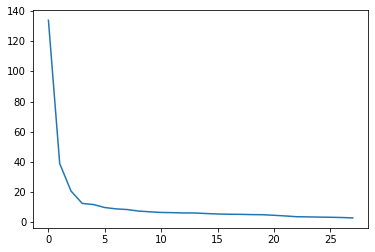

Energy up until 1 th singular value:  0.8589822466752967
Energy up until 2 th singular value:  0.9311203350630964
Energy up until 3 th singular value:  0.9513693000289403
Energy up until 4 th singular value:  0.9585881316825924
Energy up until 5 th singular value:  0.9649717527090856
Energy up until 6 th singular value:  0.9693517690320811
Energy up until 7 th singular value:  0.9729518165535392
0.0028485689390677082


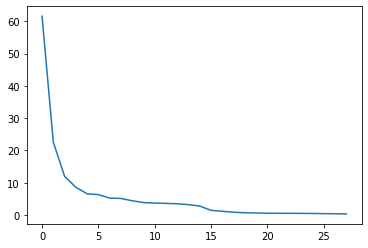

Energy up until 1 th singular value:  0.7974522455988441
Energy up until 2 th singular value:  0.9045232233844273
Energy up until 3 th singular value:  0.9347920049772268
Energy up until 4 th singular value:  0.9503831796962146
Energy up until 5 th singular value:  0.9594905115069434
Energy up until 6 th singular value:  0.9679240195535738
Energy up until 7 th singular value:  0.9737304686013524
0.002069916891254575


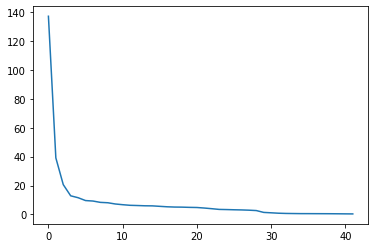

Energy up until 1 th singular value:  0.859656795228016
Energy up until 2 th singular value:  0.9296219217729459
Energy up until 3 th singular value:  0.9490443119825018
Energy up until 4 th singular value:  0.9566183333857605
Energy up until 5 th singular value:  0.9627255959347738
Energy up until 6 th singular value:  0.9669278023329062
Energy up until 7 th singular value:  0.9708438453396121
0.004956540152994848


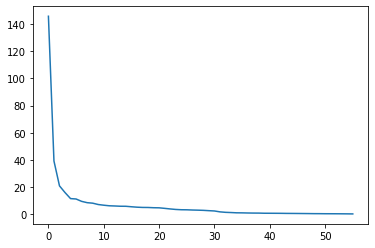

Energy up until 1 th singular value:  0.8665814223846152
Energy up until 2 th singular value:  0.9294603771075871
Energy up until 3 th singular value:  0.9473803305940064
Energy up until 4 th singular value:  0.9578710435611161
Energy up until 5 th singular value:  0.963355131734096
Energy up until 6 th singular value:  0.9685680238076878
Energy up until 7 th singular value:  0.972300906002448
0.003499479490158941
['3P_G', 'FG%', 'TOV_G', 'FT%']


In [141]:
metric_of_interest = "3P_G"
threshold = 0.97

############
df = donor.concat([metric_of_interest], 2016, total_index, method = mat_form_method)
apprx_rank = utils.approximate_rank(df, t = 0.97)
energy_captured = utils.svdAanlysis(df, title=metric_of_interest, verbose = False, k=apprx_rank)[apprx_rank-1]

metrics = [metric_of_interest]
candidates = copy.deepcopy(allMetrics)
candidates.remove(metric_of_interest)

while True:
    energy_diff_df = pd.DataFrame()
    for metric in candidates:
        comb = metrics+[metric]
        df = donor.concat(comb, 2016, total_index, method = mat_form_method)
        if (utils.approximate_rank(df, t = 0.97) == apprx_rank):
            energy_diff = np.abs(utils.svdAanlysis(df, k=apprx_rank, verbose=True)[-1] - energy_captured)
            energy_diff_df = pd.concat([energy_diff_df, pd.DataFrame([[energy_diff]], index=[metric])], axis=0)
            print(energy_diff)
    if (energy_diff_df.shape[0] == 0):
        break
    new_metric = energy_diff_df.sort_values(0).index[0]
    metrics = metrics + [new_metric]
    candidates.remove(new_metric)

print(metrics)

In [92]:
threshold = 0.97

for metric_of_interest in allMetrics:

    ############
    df = donor.concat([metric_of_interest], 2016, total_index, method = mat_form_method)
    apprx_rank = utils.approximate_rank(df, t = 0.97)
    energy_captured = utils.svdAanlysis(df, title=metric_of_interest, verbose = False)[apprx_rank-1]

    metrics = [metric_of_interest]
    candidates = copy.deepcopy(allMetrics)
    candidates.remove(metric_of_interest)

    while True:
        energy_diff_df = pd.DataFrame()
        for metric in candidates:
            comb = metrics+[metric]
            df = donor.concat(comb, 2016, total_index, method = mat_form_method)

            if (utils.approximate_rank(df, t = 0.97) == apprx_rank):

                energy_diff = np.abs(utils.svdAanlysis(df, k=apprx_rank, verbose=False)[-1] - energy_captured)
                energy_diff_df = pd.concat([energy_diff_df, pd.DataFrame([[energy_diff]], index=[metric])], axis=0)
    #             print(energy_diff)
        if (energy_diff_df.shape[0] == 0):
            break
        new_metric = energy_diff_df.sort_values(0).index[0]
        metrics = metrics + [new_metric]
        candidates.remove(new_metric)

    print(metric_of_interest)
    print(metrics)
    print()

PTS_G
['PTS_G', 'FG%', 'FT%', 'STL_G', 'TOV_G']

AST_G
['AST_G', 'PER_w', 'TOV_G', 'FG%', 'FT%', 'STL_G', 'BLK_G', '3P_G']

TOV_G
['TOV_G', 'PTS_G', 'BLK_G', 'FG%', 'FT%']

TRB_G
['TRB_G', 'FG%']

STL_G
['STL_G', 'FT%', 'FG%', 'TRB_G', 'PER_w', '3P_G', 'TOV_G', 'BLK_G']

BLK_G
['BLK_G', 'AST_G', 'FG%']

3P_G
['3P_G', 'FT%', 'FG%', 'TRB_G', 'BLK_G', 'PTS_G', 'PER_w', 'AST_G', 'STL_G']

FG%
['FG%', 'FT%', 'PER_w', 'STL_G']

FT%
['FT%', 'FG%', 'PER_w', 'STL_G']

PER_w
['PER_w', 'FG%', 'FT%', 'STL_G']



* importing data
* preparing data
